In [1]:

from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras.constraints import maxnorm
from keras import backend as K
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse, random, pickle, cv2, os, matplotlib


Using TensorFlow backend.


In [2]:
datagen = ImageDataGenerator()
data    = []
labels  = []

In [3]:
imagePaths = sorted(list(paths.list_images('./images')))
random.seed(42)
random.shuffle(imagePaths)

## Argumentation, Resize, Flatten and append to data,label lists
### Flattening: 64x64x3 = 12288

In [4]:
for imagePath in imagePaths:
	image = cv2.imread(imagePath)
	image = cv2.resize(image, (64, 64))
	data.append(image)    
	datagen.apply_transform(image,{'theta':10,'shear':10,'zx':0.2,'zy':0.2})
	datagen.apply_transform(image,{'zoom_rage':0.2,'rotation_range' : 30})
	data.append(image)
	datagen.apply_transform(image,{'theta':35,'shear':35,'zx':0.4,'zy':0.4})
	datagen.apply_transform(image,{'flip_horizontal':True})
	datagen.apply_transform(image,{'zoom_rage':0.5})
	data.append(image)
	datagen.apply_transform(image,{'theta':20,'shear':20,'zx':0.2,'zy':0.2})
	datagen.apply_transform(image,{'flip_vertical':True,'featurewise_center': True})
	datagen.apply_transform(image,{'zoom_rage':0.2})
	data.append(image)
	label = imagePath.split(os.path.sep)[-2]
	labels.append(label)
	labels.append(label)
	labels.append(label)
	labels.append(label)

In [5]:
len(data),len(labels)

(452, 452)

## Scale the raw pixel intensities to the range [0, 1] from [0, 255]

In [6]:
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)

## Train, Test split of 75, 25

In [7]:
(trainX, testX, trainY, testY) = train_test_split(data,labels, test_size=0.25, random_state=42)

In [8]:
lb = LabelBinarizer()
trainY = lb.fit_transform(trainY)
testY = lb.transform(testY)

In [9]:
model = Sequential()
model.add(ZeroPadding2D((4,4),input_shape=(64,64,3)))

model.add(Convolution2D(64,(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2), strides=(2,2)))
model.add(Convolution2D(128,(3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
model.add(Dropout(0.2))

model.add(Convolution2D(128,(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2), strides=(2,2)))
model.add(Convolution2D(256,(3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
model.add(Dropout(0.2))

model.add(Convolution2D(256,(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2), strides=(2,2)))
model.add(Convolution2D(512,(3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(1024, input_shape=(4096,), activation="relu", kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu', kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(Dense(len(lb.classes_), activation="softmax", kernel_constraint=maxnorm(3)))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_1 (ZeroPaddin (None, 72, 72, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        1792      
_________________________________________________________________
batch_normalization_1 (Batch (None, 72, 72, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 36, 36, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 18, 18, 128)       0         
__________

In [10]:
BS = 32
EPOCHS = 40
print("[INFO] training network...")
sgd = SGD(lr=0.007, decay=1e-6, nesterov=True)
model.compile(loss="categorical_crossentropy", optimizer=sgd,metrics=["accuracy"])


[INFO] training network...


In [11]:
H = model.fit(trainX, trainY, validation_data=(testX, testY),
              epochs=EPOCHS, batch_size=BS)

Train on 339 samples, validate on 113 samples
Epoch 1/40
339/339 [==============================] - 17s 49ms/step - loss: 1.8345 - acc: 0.2242 - val_loss: 1.5992 - val_acc: 0.2478
Epoch 2/40
339/339 [==============================] - 16s 48ms/step - loss: 1.6133 - acc: 0.2920 - val_loss: 1.5518 - val_acc: 0.2478
Epoch 3/40
339/339 [==============================] - 16s 47ms/step - loss: 1.5924 - acc: 0.2891 - val_loss: 1.5186 - val_acc: 0.3805
Epoch 4/40
339/339 [==============================] - 17s 51ms/step - loss: 1.5564 - acc: 0.2950 - val_loss: 1.4778 - val_acc: 0.3805
Epoch 5/40
339/339 [==============================] - 17s 49ms/step - loss: 1.4606 - acc: 0.3599 - val_loss: 1.4869 - val_acc: 0.3274
Epoch 6/40
339/339 [==============================] - 16s 47ms/step - loss: 1.4840 - acc: 0.3245 - val_loss: 1.4896 - val_acc: 0.3363
Epoch 7/40
339/339 [==============================] - 15s 45ms/step - loss: 1.4129 - acc: 0.4012 - val_loss: 1.3397 - val_acc: 0.7080
Epoch 8/40
339/3

[INFO] evaluating network...
                     precision    recall  f1-score   support

       akshay_kumar       1.00      1.00      1.00        26
       katrina_kaif       1.00      1.00      1.00        19
nawazuddin_siddiqui       0.78      1.00      0.88        14
      ranbir_kapoor       1.00      0.87      0.93        31
        zarine_khan       1.00      1.00      1.00        23

          micro avg       0.96      0.96      0.96       113
          macro avg       0.96      0.97      0.96       113
       weighted avg       0.97      0.96      0.97       113



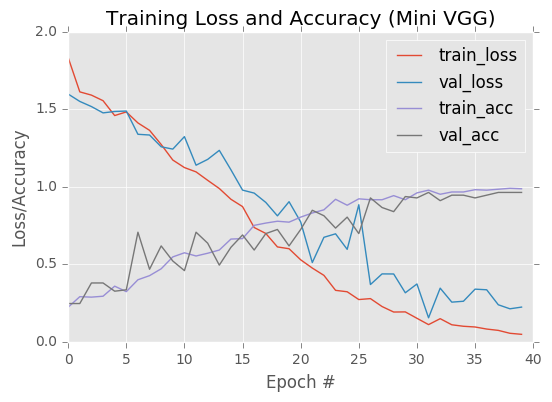

In [12]:
print("[INFO] evaluating network...")
predictions = model.predict(testX, batch_size=BS)
print(classification_report(testY.argmax(axis=1),
	predictions.argmax(axis=1), target_names=lb.classes_))
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.plot(N, H.history["acc"], label="train_acc")
plt.plot(N, H.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy (Mini VGG)")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()